In [1]:
from OnlineHDv1 import OnlineHDv1
from OnlineHDv2 import OnlineHDv2
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
path="../../../Data/malware-classification/"
with open(path+'data11.npy', 'rb') as f:
    transxtrain=np.load(f)
    transx_test=np.load(f)
    transytrain=np.load(f)
    transy_test=np.load(f)
xtr=torch.from_numpy(transxtrain).float()
xte=torch.from_numpy(transx_test).float()
ytr=torch.from_numpy(transytrain).long()
yte=torch.from_numpy(transy_test).long()

In [92]:
component1=None
conponent2=None
sum_=0
sumM_=0
onlineHDsum=None
onlineHDsumM=None
model=OnlineHDv1(classes =9, features =257, dim = 10, batch_size=64,lr=.0001)
model2=OnlineHDv2(classes =9, features =257, dim = 10, batch_size=64,lr=.0001)
model2.basis=model.basis[:]
model2.base=model.base[:]
cat=2
def cos_cdist(x1 : torch.Tensor, x2 : torch.Tensor, eps : float = 1e-8):
    #Cosine Similarity
    eps = torch.tensor(eps, device=x1.device)
    norms1 = x1.norm(dim=1).unsqueeze_(1).max(eps)
    norms2 = x2.norm(dim=1).unsqueeze_(0).max(eps)
    cdist = x1 @ x2.T
    cdist.div_(norms1).div_(norms2)
    return cdist
vals = cos_cdist(model.encode(xtr[0:cat]), model.classes)
y_pred = vals.argmax(1)
aranged = torch.arange(model.encode(xtr[0:cat]).size(0), device=model.encode(xtr[0:cat]).device)
alpha1 = (1.0 - vals[aranged,ytr[0:cat]]).unsqueeze_(1)
alpha2 = (vals[aranged,y_pred] - 1.0).unsqueeze_(1)
wrong = ytr[0:cat] != y_pred
for lbl in ytr.unique():#range(0,9)
    # print(lbl)
    m1 = wrong & (ytr[0:cat] == lbl) # mask of missed true lbl
    m2 = wrong & (y_pred == lbl) # mask of wrong preds
    # print(m1,m2)
    model.classes[lbl] += model.learningrate*(alpha1[m1]*model.encode(xtr[0:cat])[m1]).sum(0)
    # print("starting1")
    # print((self.learningrate*(alpha1[m1]*h_[m1]).sum(0)).type())
    model.classes[lbl] += model.learningrate*(alpha2[m2]*model.encode(xtr[0:cat])[m2]).sum(0)
    if lbl==0:
        onlineHDsum=(alpha2[m2]*model.encode(xtr[0:cat])[m2]).sum(0)
        onlineHDsumM=model.learningrate*(alpha2[m2]*model.encode(xtr[0:cat])[m2]).sum(0)
    if lbl==1:
        # print("#1")
        # print()
        component1=(alpha1[m1]*model.encode(xtr[0:cat])[m1]).sum(0)
    if lbl==8:
        # print("#2")
        component2=(alpha1[m1]*model.encode(xtr[0:cat])[m1]).sum(0)
    # print("alpha1")
    # print((alpha1[m1]*model.encode(xtr[0:cat])[m1]).sum(0))
    # print("alpha2")
    # print((alpha2[m2]*model.encode(xtr[0:cat])[m2]).sum(0))
# vals2 = cos_cdist(model.encode(xtr[0:cat]), model2.classes)
# model.fit(xtr[0:cat],ytr[0:cat],1)
sample = model2.encode(xtr[0:cat])
answers = ytr[0:cat]
vals = cos_cdist(sample, model2.classes)
# print(vals)
guesses = vals.argmax(1)
# print(guesses)
for j in range(0,answers.size(0)):
    if guesses[j] != answers[j]:
        # print(answers[j])
        model2.classes[guesses[j]]-=model2.learningrate*model2.encode(xtr[0:cat])[j]*(1-vals[0,guesses[j]])
        # print("newalpha1")
        # print(model2.encode(xtr[0:cat])[j]*(1-vals[0,guesses[j]]))
        # print("starting")
        # print((self.learningrate*h[i+j]*(1-vals[0,guesses[j]])).type())
        model2.classes[answers[j]]+=model2.learningrate*model2.encode(xtr[0:cat])[j]*(1-vals[0,answers[j]])
        # print("newalpha2")
        # print(model2.encode(xtr[0:cat])[j]*(1-vals[0,guesses[j]]))
        sum_+=model2.encode(xtr[0:cat])[j]*(1-vals[0,answers[j]])
        sumM_+=model2.learningrate*model2.encode(xtr[0:cat])[j]*(1-vals[0,answers[j]])
    
# model2.fit(xtr[0:cat],ytr[0:cat],1)

In [91]:
diffs=[]
for cat in range(0,13):
    model=OnlineHDv1(classes =9, features =257, dim = 10, batch_size=64,lr=.0001)
    model2=OnlineHDv2(classes =9, features =257, dim = 10, batch_size=64,lr=.0001)
    model2.basis=model.basis[:]
    model2.base=model.base[:]
    cat=2**cat
    model.fit(xtr[0:cat],ytr[0:cat],1)
    model2.fit(xtr[0:cat],ytr[0:cat],1)
    print(model2.classes)
    diffs.append(abs(float(torch.mean(model.classes-model2.classes))))

tensor([[ 7.3445189628e-05,  2.4537004720e-05, -3.1853578548e-06,
          4.6055411076e-05,  3.4897599107e-05, -1.9197419476e-07,
         -6.4663981902e-05,  6.6053083003e-08, -4.3546628149e-05,
         -4.6245739213e-05],
        [-7.3445189628e-05, -2.4537004720e-05,  3.1853578548e-06,
         -4.6055411076e-05, -3.4897599107e-05,  1.9197419476e-07,
          6.4663981902e-05, -6.6053083003e-08,  4.3546628149e-05,
          4.6245739213e-05],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00

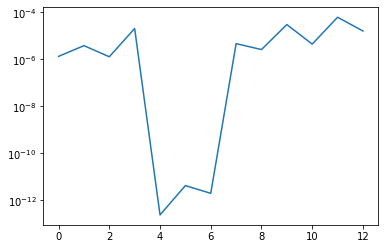

In [85]:
plt.semilogy(range(0,13), diffs)
plt.show()

In [80]:
diffs

[1.4780840729144984e-07,
 4.315495800710778e-07,
 5.582612629950745e-07,
 8.811950920062372e-07,
 1.0949960149763197e-13,
 6.343069244765104e-14,
 2.348923193538216e-13,
 3.692898644658271e-07,
 7.840392868274648e-07,
 1.7136707128884154e-06,
 4.765020094055217e-07,
 4.77461981063243e-09,
 5.642105520564655e-07]

In [27]:
torch.set_printoptions(precision=10)

In [38]:
.0001*component1+.0001*component2

tensor([-1.3672260684e-04,  3.1847543141e-05, -3.5301316530e-05,
         1.9885483198e-05, -3.6539175198e-05, -2.4686018151e-05,
         7.5383657531e-05, -4.0031241952e-05, -6.6684217018e-05,
         1.4177837875e-04])

In [29]:
component1

tensor([-0.5448373556, -0.1917609572, -0.0267266128,  0.0942810699,
        -0.2756862938,  0.0649402142,  0.0862979218, -0.2393862754,
        -0.6259303093,  0.7309558988])

In [7]:
component2

tensor([-0.8223887682,  0.5102363825, -0.3262865543,  0.1045737788,
        -0.0897054449, -0.3118003905,  0.6675386429, -0.1609261483,
        -0.0409119017,  0.6868278384])

In [8]:
.0001*onlineHDsum

tensor([ 1.3672260684e-04, -3.1847543141e-05,  3.5301316530e-05,
        -1.9885485017e-05,  3.6539171560e-05,  2.4686016332e-05,
        -7.5383657531e-05,  4.0031241952e-05,  6.6684217018e-05,
        -1.4177836420e-04])

In [9]:
.0001*sum_

tensor([-1.3672260684e-04,  3.1847543141e-05, -3.5301316530e-05,
         1.9885485017e-05, -3.6539171560e-05, -2.4686016332e-05,
         7.5383657531e-05, -4.0031241952e-05, -6.6684217018e-05,
         1.4177836420e-04])

In [10]:
onlineHDsumM

tensor([ 1.3672260684e-04, -3.1847543141e-05,  3.5301316530e-05,
        -1.9885485017e-05,  3.6539171560e-05,  2.4686016332e-05,
        -7.5383657531e-05,  4.0031241952e-05,  6.6684217018e-05,
        -1.4177836420e-04])

In [11]:
sumM_

tensor([-1.3672260684e-04,  3.1847543141e-05, -3.5301316530e-05,
         1.9885483198e-05, -3.6539175198e-05, -2.4686018151e-05,
         7.5383657531e-05, -4.0031241952e-05, -6.6684217018e-05,
         1.4177837875e-04])

In [103]:
-0.421866327524185+0.438272505998611

0.016406178474425992

In [97]:
model2.classes

tensor([[ 5.6255223171e-05,  9.4279006589e-05, -5.6762519307e-06,
         -1.5812733909e-04, -1.5222674847e-05,  9.1066431196e-07,
          7.1659378591e-06, -1.4161440777e-04, -9.9756245618e-05,
         -1.4772538270e-04],
        [-3.0087803680e-05, -3.1882595067e-05, -1.0015249245e-05,
          7.2716946306e-05, -2.5726410968e-05, -1.7349664631e-05,
         -3.2916719647e-05,  4.4538621296e-05,  9.3262118753e-05,
          6.1040140281e-05],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
          0.0000000000e+00